# PUI final exam 2021

## Theoretic part

## Question 1. 
Imagine training a model that considers multiple street segments and aims to predict the traffic based on the known characteristics of the street segments. Some of the street segments from the training sample have the observed amount of traffic specified for them, others do not. How would you classify this problem from the Machine Learning perspective?

A. Supervised learning;

B. Unsupervised learning;

C. Semi-supervised learning;

D. Reinforcement learning.

Explain your choice:

### C - Semi-supervised is a predictive model and based on labeled and unlabeled data  

## Question 2. 
Regression $y\sim a_1 x_1 + a_2 x_2 +a_3 x_3$ have p-value of $0.03$ for $x_1$, $0.3$ for $x_2$ and $0.15$ for $x_3$. Does it mean that (select all that apply):

A. Impact of $x_3$ is twice stronger than impact of $x_2$.

B. Regressors $x_2$ and $x_3$ are irrelevant.

C. One could reject the null-hypothesis $a_j=0$ only for $j=1$ but not for $j=2$ and $j=3$ at 95% singificance level.

D. The estimated value of $a_1$ is statistically significant.

E. 95%-confidence indervals for $a_2$ and $a_3$ should contain zero. 

### CDE

## Question 3. 
Which of the following statements (select all that apply) are true about overfitting problem for linear regression:

A. Overfitting problem could be detected by R-squared if the in-sample R-squared
is very low.

B. Overfitting problem often happens when we do not have enough features but a big
number of observations.

C. Overfitting problem could be detected by R-squared if the out-of-sample R-
squared is very low.

D. Overfitting problem could happen when we have many noisy features but a
small number of observations.

E. Overfitting problem could be detected by R-squared if the out-of-sample R-
squared is considerably lower compared to in-sample R-squared.

Explain how do you understand the concept of overfitting in general and in the context of your answer.

### DE

## Question 4. 
You trained the regression model with 100 regressors and 1000 observations in the training and another 1000 in the test sample. You found that in-sample R2 over the training sample is 70\% and the out-of-sample R2 over the test sample only - 30\%. (select all that apply)

a) Do you think there is any problem and how would you characterize it? Can adding more regressors (if you have them) help the model?

b) Which approaches you may use to solve the problem? 

c) What would you expect the in-sample R2 to increase or decrease after that? What about the out-of-sample (test) R2?

### a) The problem is how to solve overfitting,Adding more regressors will make model become more complicated, which increase the overfit. The Overfitting happnd when the model is too complicated given the scale of the data while adding more regressors would complicate it even further.

### b) Overfitting could be olved by reducing the complexity of the model. Dimensionality reduction such as PCA and regularization such as Prepossessing.MinMaxScale would be work. 

### c) In-sample R2 is likely to decrease after reducing the complexity of the model, but Out-of-sample R2 is expected to increase. Usually, the complexity is gradually decreasing until the gap between In-sample and out-of-sample R2 vanishes.

# import packages
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from scipy import stats

# suppress warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# import packages
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from scipy import stats
import seaborn as sns
# suppress warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
#include the distributions
from scipy.stats import norm #normal
from scipy.stats import genextreme as gev #generalized extreme value
from scipy.stats import pareto #pareto

# Traffic Modeling for Real-Time Autonomous Vehicle Solutions in LGA

Transportation network models are essential to transportation operations and planning. A simple yet well-designed linear model can provide us insights into the traffic demand. We are going to model the outgoing traffic around LGA, one of the busiest transportation hubs in NYC. 
In this test, you'll be asked to:
* Find possible correlations from observations
* Incorporate time patterns using dummy variables
* Run and diagnose linear models, in-sample and out-of-sample. Perform feature selection
* Cluster the days based on their ridership patterns to see if we can detect any outliers

We will be importing the dataset `LGAVehicleByHour.csv`,`LGAFlightArrival` providing FHV and taxi ridership and arrivals at the airport aggregated on the hourly basis:
* `vehicle_count`: Number of FHV (For Hire Vehicle) and taxi departing from LGA. This is our target variable.
* `arrivals`: Number of incoming domestic flights arriving LGA, which is assumed to provide a basis for future FHV and taxi demand

In [5]:
# import and curate the dataset
TaxiRidership = pd.read_csv("Data/LGAVehicleByHour.csv")
FlightArrival = pd.read_csv("Data/LGAFlightArrival.csv")

In [6]:
# convert the `date` feature into `dt.datetime` format. This is for later creating dummy variables
TaxiRidership.Date = pd.to_datetime(TaxiRidership.Date)
FlightArrival.Date = pd.to_datetime(FlightArrival.Date, format='%y/%m/%d %H:%M')

In [7]:
#get day of the week; monday - 0, sunday - 6
TaxiRidership['DOW']=pd.DatetimeIndex(TaxiRidership.Date).weekday

In [8]:
#get day from beginning of the year, hour and day of the week from datetime
TaxiRidership['Hour']=pd.DatetimeIndex(TaxiRidership.Date).hour

In [9]:
#get day from beginning of the year
TaxiRidership['day']=((TaxiRidership.Date-dt.datetime(2018,1,1))/dt.timedelta(days = 1)).astype(int)

## Task 1. Spatial visualization

### Q1(5+5pts extra credits) Spatial distribution of total ridership from LGA on each day of week. Using colormap 'RdBu_r', bonus on if you plot 7 plots on the same colormap scale.

In [10]:
WEEK=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
taxiZone = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=Shapefile')
taxiZone = taxiZone[['location_i', 'geometry']]
taxi = TaxiRidership.groupby(['DOW','DOLocationID']).agg({'vehicle_count':'sum'}).reset_index()

In [11]:
#calculate scale
scaleMin = taxi.vehicle_count.min() 
scaleMax = taxi.vehicle_count.max()
scaleMean = taxi.vehicle_count.mean()
print("max: ", scaleMax, " Min: ", scaleMin, " Mean: ", scaleMean)


max:  48129.0  Min:  0.0  Mean:  3018.8560311284045


In [12]:
# merge geometry
taxi = taxiZone.merge(taxi, left_on='location_i', right_on='DOLocationID')
taxi = taxi.drop(columns=['location_i'])
taxi.head()

,geometry,DOW,DOLocationID,vehicle_count
0,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",0,1,1049.0
1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",1,1,1020.0
2,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",2,1,969.0
3,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",3,1,1009.0
4,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",4,1,1294.0


In [13]:
# make sure every DOLocationID could get a geometry info
len(TaxiRidership[~TaxiRidership['DOLocationID'].isin(taxiZone.location_i.unique())])

0

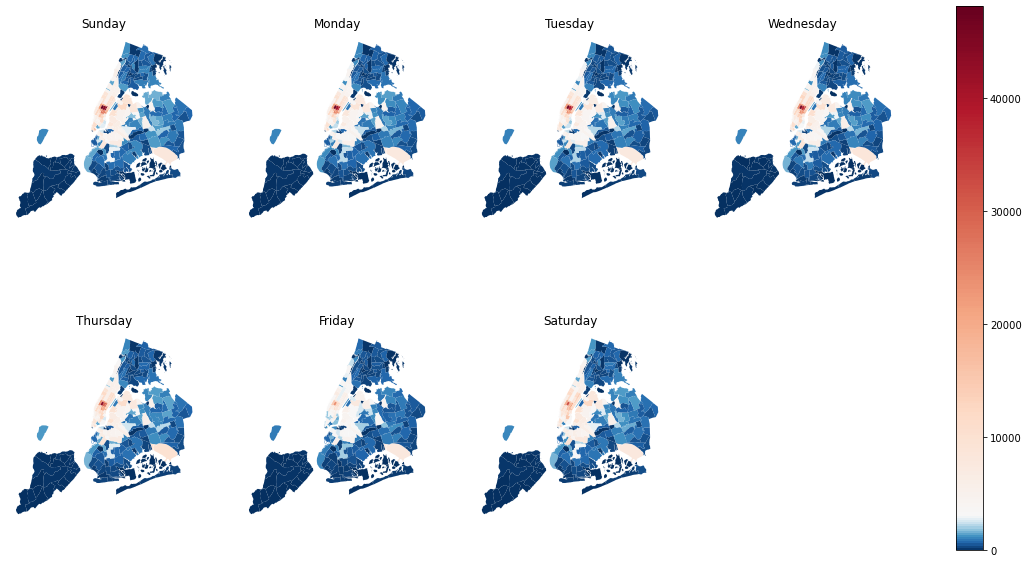

In [14]:
cnorm = mcolors.TwoSlopeNorm(vmin=scaleMin, vcenter=scaleMean, vmax=scaleMax)

fig,ax = plt.subplots(2,4,figsize=(20,10))
for day in range(0,7):
    taxi[taxi['DOW']==day].plot(ax=ax[int(day/4),day%4], norm=cnorm, column='vehicle_count', legend=False, cmap='RdBu_r')
    ax[int(day/4),day%4].set_title(WEEK[day-1])
    ax[int(day/4),day%4].axis('off')
ax[1,3].axis('off')

cbar = plt.cm.ScalarMappable(norm=cnorm, cmap='RdBu_r')
fig.colorbar(cbar, ax=ax).ax.tick_params(labelsize=10)

## Task 2: Data preprocessing

### Q1 (3pts), aggregate ridership to date-hour level (over the entire city for all the drop off locations aggregated together), merge with the flight arrival data

In [15]:
task2taxi = TaxiRidership[['Date','Hour','vehicle_count']].groupby(['Date','Hour'], as_index=False).sum()
task2 = FlightArrival.merge(task2taxi, on='Date')
task2.head()

,Date,arrivals,Hour,vehicle_count
0,2018-01-01 00:00:00,3,0,142.0
1,2018-01-01 01:00:00,0,1,23.0
2,2018-01-01 02:00:00,1,2,2.0
3,2018-01-01 03:00:00,0,3,1.0
4,2018-01-01 04:00:00,0,4,13.0


### Q2(3pts), add time-lagged arrivals (1,2,3,4,5,6..12 hours before)

Taxi and FHV ridership volume is impacted by flight arrivals. Intuitively, more flights bring more passengers, and more ridership eventually. However, the hourly ridership volume may not only related to flight arrivals in the same hour, arrivals in 1 hour, 2 hours ago could impact ridership as well, as travelers need some time to pass the costume or wait for luggage. Please add lag add of `arrivals` as additional features, and name new features as `lag1` for `arrivals` 1 hour ago, and `lag2` for 2 hours before and so on. You may use the `shift` function in pandas to add arrivals lag values. For example, df['arrivals'].shift(1) means add 1 hour lag value of arrivals. `iloc` function works as well.

In [16]:
LAGS=['lag1','lag2','lag3','lag4','lag5','lag6','lag7','lag8','lag9','lag10','lag11','lag12']
for i in range(0,12):
    task2[LAGS[i]] = task2['arrivals'].shift(i+1, fill_value=0)
task2.head()

,Date,arrivals,Hour,vehicle_count,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
0,2018-01-01 00:00:00,3,0,142.0,0,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-01 01:00:00,0,1,23.0,3,0,0,0,0,0,0,0,0,0,0,0
2,2018-01-01 02:00:00,1,2,2.0,0,3,0,0,0,0,0,0,0,0,0,0
3,2018-01-01 03:00:00,0,3,1.0,1,0,3,0,0,0,0,0,0,0,0,0
4,2018-01-01 04:00:00,0,4,13.0,0,1,0,3,0,0,0,0,0,0,0,0


In [17]:
df = task2

In [18]:
df['DOW']=pd.DatetimeIndex(df.Date).weekday
df['month']=df['Date'].dt.month
df['day']=((df.Date-dt.datetime(2018,1,1))/dt.timedelta(days = 1)).astype(int)

## Task 3. Data Exploration

### Q1 (3pts). Print some dataset characteristics: number of records, the total number of FHV and taxi trips, total number of arriving flights


In [19]:
print("total number of record", df.shape[0])
print("total number of FHV", df['vehicle_count'].sum())
print("total number of taxi trips", TaxiRidership['vehicle_count'].shape[0])
print("total number of arriving flights", df['arrivals'].sum())

total number of record 8760
total number of FHV 5430922.0
total number of taxi trips 2251320
total number of arriving flights 163713


### Q2 (8pts, 4 pts for the figure, 4 pts for the t-test). Plot a probability distribution function of hourly ridership volume on weekdays and weekend, and apply t-test to check is there a significant difference of hourly ridership between each day of week and the rest days, $\alpha=0.05$ Report hypothesis testing result in a $7\times1$ table, index name should be day of week (e.g. Monday), values should be True or False (True for P < 0.05).
Hint: You may use norm.pdf function in scipy.stats to calculate the probability distribution, and standardize at first.

In [20]:
#introduce a custom function performing distribution analysis
def distribution_analysis(x, log_scale = False, bins = 50, vis_means = True, vis_curve = True, print_outputs = True):
    #x - array of observations
    #log_scale - analyze distribution of log(x) if True
    #fit_distribution - fit the distribution ('normal', 'gev' or 'pareto') or do nothing if 'None'
    #bins - how many bins to use for binning the data
    #vis_means - show mean and std lines if True
    #vis_curve - show interpolated distribution curve over the histogram bars if True
    #print_outputs - print mean, std and percentiles
    
    if log_scale: 
        x1 = np.log10(x) #convert data to decimal logarithms
        xlabel = 'log(values)' #reflect in x labels
    else:
        x1 = x #leave original scale 
        xlabel = 'values'
    mu = x1.mean() #compute the mean
    if log_scale: #if logscale, output all three - log mean, its original scale and original scale mean
        print('Log mean = {:.2f}({:.2f}), mean = {:.2f}'.format(mu,10**mu,x.mean()))
    else:
        print('Mean = {:.2f}'.format(mu)) #otherwise print mean
    sigma = x1.std() #compute and output standard deviation 
    print('Standard deviation = {:.2f}'.format(sigma))
    for p in [1,5,25,50,75,95,99]: #output percentile values
        print('{:d} percentile = {:.2f}'.format(p,np.percentile(x1,p))) #----------------------自行更改 x => x1
        
    #visualize histogram and the interpolated line (if vis_curve=True) using seaborn
    sns.distplot(x1, hist=True, kde=vis_curve, 
        bins=bins,color = 'darkblue', 
        hist_kws={'edgecolor':'black'},
        kde_kws={'linewidth': 4})
    
    #show vertical lines for mean and std if vis_means = True
    if vis_means:
        plt.axvline(mu, color='r', ls='--', lw=2.0)
        plt.axvline(mu-sigma, color='g', ls='--', lw=2.0)
        plt.axvline(mu+sigma, color='g', ls='--', lw=2.0)
        
    ylim = plt.gca().get_ylim() #keep the y-range of original distribution density values 
    #(to make sure the fitted distribution would not affect it)
    
    h = np.arange(mu - 3 * sigma, mu + 3 * sigma, sigma / 100) #3-sigma visualization range for the fitted distribution
    pars = None #fitted distribution parameters
    
    #fit and visualize the theoretic distribution
    pars = norm.fit(x1)
    plt.plot(h,norm.pdf(h,*pars),'r')
    plt.xlabel(xlabel) #add x label 
    plt.ylim(ylim) #restore the y-range of original distribution density values 
    plt.show()
    
    return pars

Mean = 505.21
Standard deviation = 432.20
1 percentile = 1.00
5 percentile = 3.00
25 percentile = 53.00
50 percentile = 467.00
75 percentile = 770.50
95 percentile = 1336.25
99 percentile = 1558.40


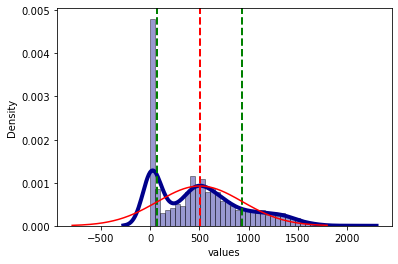

In [21]:
distribution_analysis(df.loc[df['DOW']>4]['vehicle_count'], bins=40);

Mean = 665.69
Standard deviation = 451.45
1 percentile = 1.00
5 percentile = 3.00
25 percentile = 127.50
50 percentile = 801.00
75 percentile = 1021.00
95 percentile = 1275.00
99 percentile = 1454.59


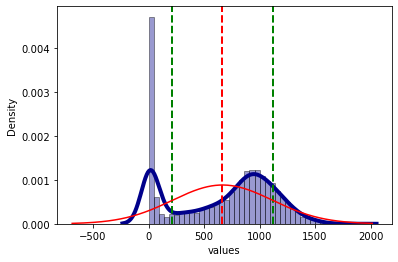

In [22]:
distribution_analysis(df.loc[df['DOW']<=4]['vehicle_count'], bins=40);

In [23]:
table = pd.DataFrame(columns=['significant'], index=WEEK)
for i in range(0,7):
    t_test = stats.ttest_ind(df.loc[df['DOW']==i]['vehicle_count'],
                             df.loc[df['DOW']!=i]['vehicle_count'])
    table.iloc[i]['significant'] = True if t_test[1] < 0.05 else False
table

,significant
Monday,True
Tuesday,False
Wednesday,False
Thursday,True
Friday,True
Saturday,True
Sunday,False


### Q3(10pts, 3 pts for locate the correct month, 7 pts for the figure.) .  Plot the timeline of the `vehicle_count` and `arrivals` for the month having the highest taxi ridership (the sum of vehicle count in the whole month). As `arrivals` and `vehicle_count` have different scales, standardize each dataset first.

In [24]:
# get the largest sum of vehicle count in the whole month
df[['month','vehicle_count']].groupby(['month']).sum().idxmax()['vehicle_count']

10

In [25]:
Oct = df[df['month']==10]
Oct.shape

(744, 19)

In [26]:
taxi = Oct[['vehicle_count','day']].groupby('day').sum()
taxi.head()

,vehicle_count
day,
273,18194.0
274,12905.0
275,20099.0
276,18893.0
277,18624.0


In [27]:
flight = Oct[['arrivals','day']].groupby('day').sum()
flight.head()

,arrivals
day,
273,530
274,480
275,522
276,535
277,535


In [28]:
list(taxi.index)[0]

273

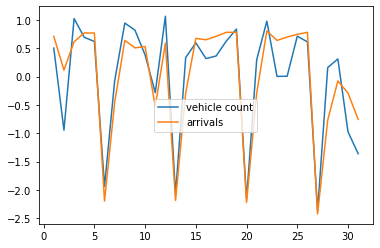

In [29]:
# standardize
min_max_scaler = preprocessing.StandardScaler()
flight['norm'] = min_max_scaler.fit_transform(flight)
taxi['norm'] = min_max_scaler.fit_transform(taxi)

# visualize
plt.plot(taxi.index-list(taxi.index)[0]+1, taxi['norm'], label='vehicle count')
plt.plot(flight.index-list(flight.index)[0]+1, flight['norm'], label='arrivals')
plt.legend()
plt.show()

## Task 4: Build Linear Regression Model of FHV and taxi ridership vs Arrivals data

### Q1 (3pts). split the data into training, validation and test samples (first 90 days for training, next 180 for validation, last 90 for test)


In [30]:
train=df.loc[df.day<90,:]
valid=df.loc[(df.day>=90)&(df.day<270),:]
test=df.loc[df.day>=270,:]

### Q2 (10pts, 6 pts for modeling, 2 pts for the confidence interval, 2 pts for the figure.). 

Build an OLS model with intercept (you may want to use smf.ols) over the training dataset using `arrivals` as a sole predictor for `vehicle_count`. Check p-value for arrival. What does it indicate? Report the 99% confidence interval for arrival's coefficient. Scatter plot for taxi ridership and flight arrival, include the predictive line from linear regression report.

In [31]:
lm = smf.ols(formula='vehicle_count~arrivals', data = train).fit()
lm.summary(alpha=0.01)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          vehicle_count   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     5657.
Date:                Sun, 26 Dec 2021   Prob (F-statistic):               0.00
Time:                        09:00:19   Log-Likelihood:                -14690.
No. Observations:                2160   AIC:                         2.938e+04
Df Residuals:                    2158   BIC:                         2.939e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.005      0.995]
------------------------------------------------------------------------------
Intercept     75.8315      7.772      9.757      0.000      55.795      95.868
arrivals      26.2834      0.349     75.210      0.000      25.382      27.184
==============================================================================
Omnibus:                      287.221   Durbin-Watson:                   0.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              655.473
Skew:                           0.772   Prob(JB):                    4.63e-143
Kurtosis:                       5.213   Cond. No.                         37.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
lm.conf_int(alpha=0.01).at['arrivals', 0]

25.38239440770063

In [33]:
CIlow = lm.conf_int(alpha=0.01).at['arrivals', 0]
CIhigh = lm.conf_int(alpha=0.01).at['arrivals', 1]
print("arrivals p value: ", lm.pvalues['arrivals'])
print("99% CI is [{0},{1}]".format(CIlow, CIhigh))

arrivals p value:  0.0
99% CI is [25.38239440770063,27.184321755411347]


<span style="color:red;font-size:18pt">pvalue < 0.99 reject the hypothesis that arrival has no relation with fhv. arrivals is significant</span>

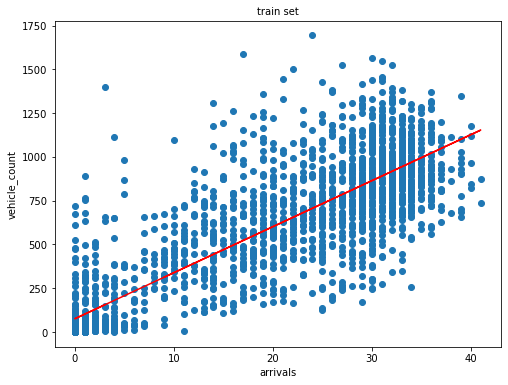

In [34]:
plt.figure(figsize=(8,6))
plt.plot(train['arrivals'], train['vehicle_count'], 'o')
plt.title('train set', fontsize = 10)
plt.xlabel('arrivals')
plt.ylabel('vehicle_count')
plt.plot(train['arrivals'], lm.predict(train['arrivals']), '-r')

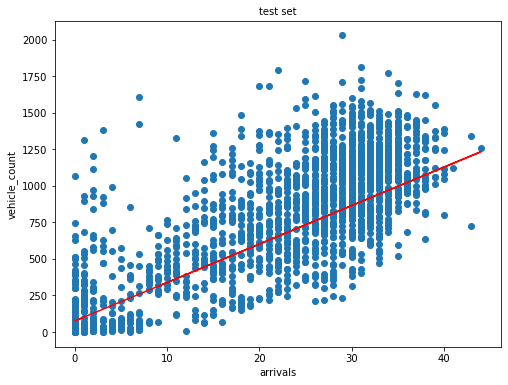

In [35]:
plt.figure(figsize=(8,6))
plt.plot(test['arrivals'], test['vehicle_count'], 'o')
plt.title('test set', fontsize = 10)
plt.xlabel('arrivals')
plt.ylabel('vehicle_count')
plt.plot(test['arrivals'], lm.predict(test['arrivals']), '-r')

### Q3 (8pts): Consider Impact of immediate history of arrivals
by adding time lags - add all 12 lag variables into the regression above

There is always some delay between passengers arrival and departure (e.g. passing customs, picking up luggage, etc). `vehicle_count` might be more related to historical values of flight arrivals (lag) rather than immediate `arrivals`. Engineer a formula with all the following variables and run the regression:
* arrival, lag1, ..., lagN: that happens 1hr, ..., N=12 hr ahead.
Which of the variables have a statistically significant impact according to p-values?


In [36]:
lm2 = smf.ols(formula = 'vehicle_count ~ arrivals +' + ' + '.join(LAGS), data = train).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          vehicle_count   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     1012.
Date:                Sun, 26 Dec 2021   Prob (F-statistic):               0.00
Time:                        09:00:19   Log-Likelihood:                -13957.
No. Observations:                2160   AIC:                         2.794e+04
Df Residuals:                    2146   BIC:                         2.802e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -51.0989      9.390     -5.442      0.000     -69.513     -32.685
arrivals      10.9149      0.529     20.615      0.000       9.877      11.953
lag1          13.3212      0.684     19.485      0.000      11.981      14.662
lag2           5.7680      0.688      8.381      0.000       4.418       7.118
lag3           1.4042      0.690      2.036      0.042       0.052       2.757
lag4          -1.3087      0.692     -1.890      0.059      -2.667       0.049
lag5           0.5963      0.693      0.861      0.389      -0.762       1.955
lag6          -0.4923      0.683     -0.721      0.471      -1.832       0.847
lag7           0.9881      0.693      1.426      0.154      -0.371       2.347
lag8           1.2618      0.693      1.821      0.069      -0.097       2.621
lag9           1.8996      0.690      2.752      0.006       0.546       3.253
lag10         -0.8283      0.689     -1.202      0.229      -2.179       0.523
lag11          0.9669      0.684      1.413      0.158      -0.375       2.309
lag12         -1.0439      0.529     -1.972      0.049      -2.082      -0.006
==============================================================================
Omnibus:                      390.468   Durbin-Watson:                   0.816
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              900.055
Skew:                           1.014   Prob(JB):                    3.59e-196
Kurtosis:                       5.427   Cond. No.                         197.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<span style="color:red;font-size:18pt">lag1, lag2, lag3, lag9, lag12 are significant</span>

### Q4(5pt): Incorporate Temporal Patterns 

adding categorical variables for day of week and hour of the day.

From the visualization in task1Q3, you may see that both - taxi ridership as well as arrivals follow a somewhat periodic temporal pattern. Intuitively, this is true for most traffic flows following daily rhythms including rush hours, and also varying over the course of the week. Usually, we add dummy/categorical variables (Boolean variable: 1 for True and 0 for False) to encapsulate people's traveling patterns during different time periods.

Note that it would not make sense to add hour and dow as regular regressors as we can't anticipate their linear numeric impact. Instead, the expression `C(.)` or `pd.get_dummies` could be used in the regression formulae in order to treat those variables as categorical adding corresponding dummy variables to account for their possible discrete values. 

Perform the regression of `vehicle_count` ridership against `arrivals`, lags, and temporal categorical variables.

In [37]:
lm3=smf.ols(formula = 'vehicle_count ~ arrivals +' + ' + '.join(LAGS) + '+ C(DOW) + C(Hour)', data = train).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          vehicle_count   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     453.6
Date:                Sun, 26 Dec 2021   Prob (F-statistic):               0.00
Time:                        09:00:19   Log-Likelihood:                -13592.
No. Observations:                2160   AIC:                         2.727e+04
Df Residuals:                    2117   BIC:                         2.752e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        66.1512     22.680      2.917      0.004      21.674     110.629
C(DOW)[T.1]     -72.6308     10.635     -6.830      0.000     -93.486     -51.776
C(DOW)[T.2]     -95.1384     10.779     -8.826      0.000    -116.277     -74.000
C(DOW)[T.3]     -21.7931     10.596     -2.057      0.040     -42.573      -1.013
C(DOW)[T.4]     -57.0345     10.649     -5.356      0.000     -77.918     -36.151
C(DOW)[T.5]     -77.3302     11.643     -6.642      0.000    -100.164     -54.497
C(DOW)[T.6]       8.2757     11.360      0.728      0.466     -14.002      30.554
C(Hour)[T.1]   -119.8431     21.125     -5.673      0.000    -161.270     -78.416
C(Hour)[T.2]    -80.5772     22.292     -3.615      0.000    -124.293     -36.862
C(Hour)[T.3]    -53.9145     23.619     -2.283      0.023    -100.233      -7.596
C(Hour)[T.4]    -48.6502     24.454     -1.989      0.047     -96.607      -0.694
C(Hour)[T.5]    -40.7493     24.647     -1.653      0.098     -89.083       7.585
C(Hour)[T.6]    -45.7692     25.457     -1.798      0.072     -95.692       4.154
C(Hour)[T.7]    -35.1022     29.997     -1.170      0.242     -93.930      23.725
C(Hour)[T.8]    -47.9236     30.951     -1.548      0.122    -108.621      12.774
C(Hour)[T.9]      6.8804     31.397      0.219      0.827     -54.693      68.454
C(Hour)[T.10]    35.7873     31.526      1.135      0.256     -26.037      97.612
C(Hour)[T.11]    -4.8611     29.840     -0.163      0.871     -63.380      53.658
C(Hour)[T.12]    11.9344     29.039      0.411      0.681     -45.014      68.883
C(Hour)[T.13]   -14.7916     28.986     -0.510      0.610     -71.636      42.053
C(Hour)[T.14]    31.5266     29.592      1.065      0.287     -26.505      89.558
C(Hour)[T.15]    52.9388     29.705      1.782      0.075      -5.315     111.193
C(Hour)[T.16]    66.0308     29.346      2.250      0.025       8.481     123.581
C(Hour)[T.17]    98.1921     28.625      3.430      0.001      42.057     154.328
C(Hour)[T.18]    98.4294     26.895      3.660      0.000      45.685     151.174
C(Hour)[T.19]   124.3245     23.521      5.286      0.000      78.197     170.452
C(Hour)[T.20]   100.1563     23.089      4.338      0.000      54.878     145.435
C(Hour)[T.21]   244.3750     22.945     10.651      0.000     199.378     289.372
C(Hour)[T.22]   208.3532     21.997      9.472      0.000     165.215     251.492
C(Hour)[T.23]   245.3463     20.991     11.688      0.000     204.181     286.512
arrivals         10.1500      0.644     15.772      0.000       8.888      11.412
lag1             11.3252      0.715     15.837      0.000       9.923      12.728
lag2              3.6712      0.731      5.023      0.000       2.238       5.104
lag3              1.2403      0.730      1.698      0.090      -0.192       2.672
lag4             -0.4001      0.730     -0.548   

In [38]:
lm3.pvalues.index[lm3.pvalues<0.05]

Index(['Intercept', 'C(DOW)[T.1]', 'C(DOW)[T.2]', 'C(DOW)[T.3]', 'C(DOW)[T.4]',
       'C(DOW)[T.5]', 'C(Hour)[T.1]', 'C(Hour)[T.2]', 'C(Hour)[T.3]',
       'C(Hour)[T.4]', 'C(Hour)[T.16]', 'C(Hour)[T.17]', 'C(Hour)[T.18]',
       'C(Hour)[T.19]', 'C(Hour)[T.20]', 'C(Hour)[T.21]', 'C(Hour)[T.22]',
       'C(Hour)[T.23]', 'arrivals', 'lag1', 'lag2', 'lag9'],
      dtype='object')

### Q5 (8pts, no penalty if students got different results, but no points if students failed to complete 12 models). Perform feature selection for lag variables
As you may see not all the lag variables have a statistically significant impact on the regression. Maybe some of them are not really relevant?
Try different amounts of lag variables m=0,1,...,12 (include m most recent arrival volumes/lags) using a loop for training the above regression over the training sample, report and plot the out-of-sample R2 over the validation sample as the function of m and pick the m which maximizes it. Evaluate the final regression over the test sample.

In [39]:
R2=[]
columns = ['arrivals','Hour','DOW']
for i in range(0,12):
    if(i>=1):
        columns.append("lag%d"%i)
    formula='vehicle_count ~ '+'+'.join(columns);
    lm = smf.ols(formula = formula, data = train).fit()
    r2 = r2_score(valid.vehicle_count,lm.predict(valid))
    R2.append(r2)
    print(r2, formula)

0.7421703616031587 vehicle_count ~ arrivals+Hour+DOW
0.826306849890811 vehicle_count ~ arrivals+Hour+DOW+lag1
0.8340068232765722 vehicle_count ~ arrivals+Hour+DOW+lag1+lag2
0.8326686200403772 vehicle_count ~ arrivals+Hour+DOW+lag1+lag2+lag3
0.8326730050082604 vehicle_count ~ arrivals+Hour+DOW+lag1+lag2+lag3+lag4
0.8326045787228709 vehicle_count ~ arrivals+Hour+DOW+lag1+lag2+lag3+lag4+lag5
0.8328103906429498 vehicle_count ~ arrivals+Hour+DOW+lag1+lag2+lag3+lag4+lag5+lag6
0.8349429653336038 vehicle_count ~ arrivals+Hour+DOW+lag1+lag2+lag3+lag4+lag5+lag6+lag7
0.8371959912837339 vehicle_count ~ arrivals+Hour+DOW+lag1+lag2+lag3+lag4+lag5+lag6+lag7+lag8
0.8387567328117791 vehicle_count ~ arrivals+Hour+DOW+lag1+lag2+lag3+lag4+lag5+lag6+lag7+lag8+lag9
0.8387938253018106 vehicle_count ~ arrivals+Hour+DOW+lag1+lag2+lag3+lag4+lag5+lag6+lag7+lag8+lag9+lag10
0.8393249515365606 vehicle_count ~ arrivals+Hour+DOW+lag1+lag2+lag3+lag4+lag5+lag6+lag7+lag8+lag9+lag10+lag11


In [40]:
m=R2.index(max(R2));m

11

<span style="color:red;font-size:18pt">m = 11 has the largest r2</span>

In [41]:
lm4 = smf.ols(formula = 'vehicle_count~arrivals+'+'+'.join(LAGS[:m])+'+C(Hour)+C(DOW)', data = train).fit()
pred = lm4.predict(test)
r2 = r2_score(test.vehicle_count, pred)
print("test R2: ", r2)

test R2:  0.8214008910404746


### Q6 (9pts, 3 pts for each figure). Visualize temporal patterns and lag impacts through bar plots
For the best regression above, visualize:
- bar plot of hour vs its impact coefficient
- bar plot of day of the week vs its impact coefficient
- bar plot of the lag (0 for immediate arrivals, 1,2,... for lags)

<BarContainer object of 23 artists>

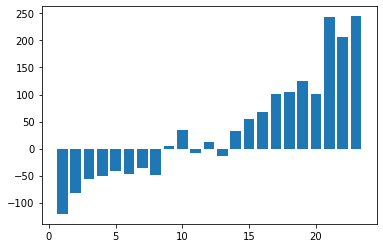

In [42]:
plt.bar(range(1,24),lm4.params[1:24])

<BarContainer object of 6 artists>

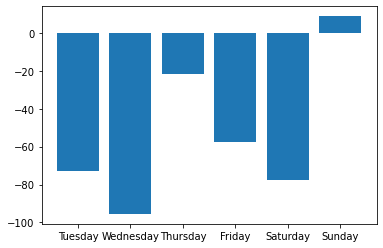

In [43]:
plt.bar(WEEK[1:],lm4.params[24:30])

<BarContainer object of 11 artists>

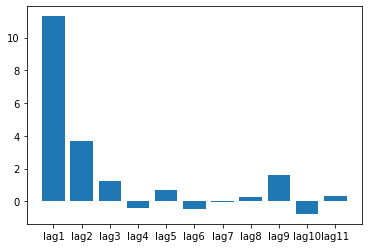

In [44]:
plt.bar(LAGS[:m],lm4.params[31:])

## Task 5. Cluster the days of the year based on the relative timeline of their taxi departures from the airport

### Q1 (3pts). From the entire `dataset`, create a dataframe with days as rows, hours as columns, and taxi ridership as values (feel free to use pd.pivot_table). Normalize each row by the total daily ridership

In [45]:
table = pd.pivot_table(df[['Hour','day', 'vehicle_count']], index='day', columns='Hour')
table.columns = list(range(0,24))
table = table.div(table.sum(axis=1), axis=0)
table

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
0,0.011312,0.001832,0.000159,0.000080,0.001036,0.001036,0.001195,0.003664,0.019756,0.035290,...,0.060942,0.068908,0.061818,0.094161,0.064048,0.060942,0.059269,0.081654,0.095276,0.085956
1,0.053023,0.003352,0.001877,0.000134,0.000335,0.001073,0.001609,0.020177,0.036868,0.074876,...,0.059794,0.043572,0.054967,0.062140,0.065625,0.063011,0.054364,0.070251,0.069312,0.049269
2,0.055675,0.025525,0.001982,0.000248,0.000661,0.000991,0.003635,0.014538,0.043863,0.064183,...,0.057823,0.056831,0.074922,0.083512,0.071948,0.058896,0.041880,0.039650,0.046754,0.024864
3,0.248316,0.009259,0.001684,0.000842,0.008418,0.012626,0.036195,0.026094,0.026936,0.024411,...,0.057239,0.067340,0.033670,0.037879,0.024411,0.023569,0.017677,0.026936,0.031145,0.060606
4,0.033489,0.014192,0.002510,0.001298,0.000606,0.001211,0.003115,0.007961,0.007702,0.020076,...,0.051142,0.058757,0.062565,0.076411,0.076324,0.082208,0.077362,0.091295,0.065853,0.082814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.038981,0.008450,0.003544,0.000204,0.000273,0.001159,0.004089,0.011858,0.047295,0.058812,...,0.058539,0.065967,0.054927,0.067943,0.075508,0.077416,0.062355,0.041093,0.064195,0.045318
361,0.028664,0.040007,0.023785,0.004025,0.000854,0.000915,0.003964,0.012197,0.032689,0.046899,...,0.057998,0.059584,0.059950,0.058913,0.065561,0.061170,0.055315,0.071172,0.074038,0.043971
362,0.045037,0.009984,0.000287,0.000431,0.000359,0.002155,0.004597,0.008763,0.033329,0.043313,...,0.047694,0.070033,0.060623,0.062994,0.073696,0.068525,0.077719,0.075277,0.050998,0.054949


### Q2 (8pts, no penalty if students got different results, but no points if the silhoutte score from different clusters are missing). Try K-means with different numbers of clusters k=2..7, reporting average Silhouette score for each. Which k is the "optimal" from Silhouette's standpoint?

In [46]:
range_n_clusters = [2, 3, 4, 5, 6, 7]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(table)
    #report average Silhouette score
    silhouette_avg = silhouette_score(table, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.1892982498549995
For n_clusters =3, the average silhouette_score is :0.22324051576230963
For n_clusters =4, the average silhouette_score is :0.23329518409569272
For n_clusters =5, the average silhouette_score is :0.22514662772630323
For n_clusters =6, the average silhouette_score is :0.1760282734467836
For n_clusters =7, the average silhouette_score is :0.17725740332000375


<span style="color:red;font-size:18pt">the highest one is acheived for k=4</span>

### Q3 (10pts, 3 pts for data processing, 7 for the pivot table). Perform K-means with the optimal k from above. Report the number of occurrences of each day of the week within each of the clusters. How would you interpret the clusters based on that? Visualize the aggregated hourly timeline over all the days within each cluster.
Create a dictionary of the cluster numbers corresponding to each day of the year, apply it adding a column "cluster" to the dataframe, and use pivot table with aggregation function `count` to collect the numbers above. Also, use the pivot table to collect total riders per hour of the day within each cluster for further visualization (after appropriate normalization by the grand total).

In [47]:
km = KMeans(n_clusters=4, random_state=324)
cluster_labels = km.fit_predict(table)
dayCluster={i:cluster_labels[i] for i in range(len(cluster_labels))}
df['Cluster']=df.day.map(dayCluster)
df.head()

,Date,arrivals,Hour,vehicle_count,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,DOW,month,day,Cluster
0,2018-01-01 00:00:00,3,0,142.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2018-01-01 01:00:00,0,1,23.0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2018-01-01 02:00:00,1,2,2.0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2018-01-01 03:00:00,0,3,1.0,1,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2018-01-01 04:00:00,0,4,13.0,0,1,0,3,0,0,0,0,0,0,0,0,0,1,0,0


In [48]:
pd.pivot_table(df[['day','DOW','Cluster']].drop_duplicates(),values='day', index='DOW',columns='Cluster', aggfunc='count',fill_value=0)

Cluster,0,1,2,3
DOW,,,,
0,6,37,7,3
1,4,42,6,0
2,4,41,5,2
3,15,30,6,1
4,6,33,11,2
5,1,2,9,40
6,49,3,0,0


<span style="color:red;font-size:18pt"> Cluster 1: Weekdays, Cluster 3: Saturday, Cluster 0: Sunday</span>

### Q4(4pts) visualize the hourly timeline for each cluster, and normalize by total riderships in the cluster.

<AxesSubplot:xlabel='Hour'>

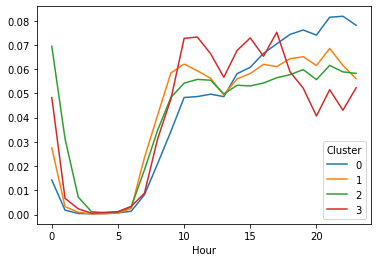

In [49]:
table=pd.pivot_table(task2,values='vehicle_count', index='Hour',columns='Cluster', aggfunc='sum')
table/=table.sum()
table.plot()